In [51]:
# import libraries
import os
import torch
from torch import nn
import random
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from torchinfo import summary
from tqdm.auto import tqdm

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [53]:
data_path = Path("../../../dataset")
training_dir = data_path / "neu_defect/train/images"
validation_dir = data_path / "neu_defect/validation/images"

for dirpath, dirnames, filenames in os.walk(training_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 6 directories and 0 images in '..\..\..\dataset\neu_defect\train\images'.
There are 0 directories and 240 images in '..\..\..\dataset\neu_defect\train\images\crazing'.
There are 0 directories and 240 images in '..\..\..\dataset\neu_defect\train\images\inclusion'.
There are 0 directories and 240 images in '..\..\..\dataset\neu_defect\train\images\patches'.
There are 0 directories and 240 images in '..\..\..\dataset\neu_defect\train\images\pitted_surface'.
There are 0 directories and 240 images in '..\..\..\dataset\neu_defect\train\images\rolled-in_scale'.
There are 0 directories and 240 images in '..\..\..\dataset\neu_defect\train\images\scratches'.


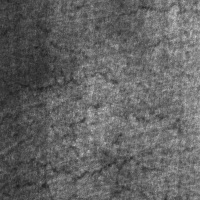

In [54]:
# visualize random training image
image_path_list = list(training_dir.glob("*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

img

In [55]:
train_transform = v2.Compose([
    v2.Resize(size = (64, 64)),
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.ToDtype(torch.float32, scale = True),
])

val_transform = v2.Compose([
    v2.Resize(size = (64, 64)),
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    v2.ToDtype(torch.float32, scale = True),
])

In [56]:
training_dataset = datasets.ImageFolder(
    root = training_dir,
    transform = train_transform,
    target_transform = None
)

validation_dataset = datasets.ImageFolder(
    root = validation_dir,
    transform = val_transform,
    target_transform = None
)

class_names = training_dataset.classes
class_dict = training_dataset.class_to_idx

len(training_dataset)

1440

In [57]:
img, label = training_dataset[0][0], training_dataset[0][1]

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
Image([[[0.7490, 0.8039, 0.7451,  ..., 0.5529, 0.4745, 0.3961],
        [0.7922, 0.8902, 0.8078,  ..., 0.5686, 0.5176, 0.4627],
        [0.8078, 0.8706, 0.8471,  ..., 0.5333, 0.5020, 0.4784],
        ...,
        [0.8706, 0.8431, 0.8588,  ..., 0.5176, 0.4471, 0.3451],
        [0.9176, 0.9098, 0.8941,  ..., 0.5020, 0.5608, 0.4471],
        [0.8745, 0.8196, 0.8627,  ..., 0.6314, 0.5922, 0.5569]],

       [[0.7490, 0.8039, 0.7451,  ..., 0.5529, 0.4745, 0.3961],
        [0.7922, 0.8902, 0.8078,  ..., 0.5686, 0.5176, 0.4627],
        [0.8078, 0.8706, 0.8471,  ..., 0.5333, 0.5020, 0.4784],
        ...,
        [0.8706, 0.8431, 0.8588,  ..., 0.5176, 0.4471, 0.3451],
        [0.9176, 0.9098, 0.8941,  ..., 0.5020, 0.5608, 0.4471],
        [0.8745, 0.8196, 0.8627,  ..., 0.6314, 0.5922, 0.5569]],

       [[0.7490, 0.8039, 0.7451,  ..., 0.5529, 0.4745, 0.3961],
        [0.7922, 0.8902, 0.8078,  ..., 0.5686, 0.5176, 0.4627],
        [0.8078, 0.8706, 0.8471,  ..., 0.5333, 0.5020, 0.478

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'crazing')

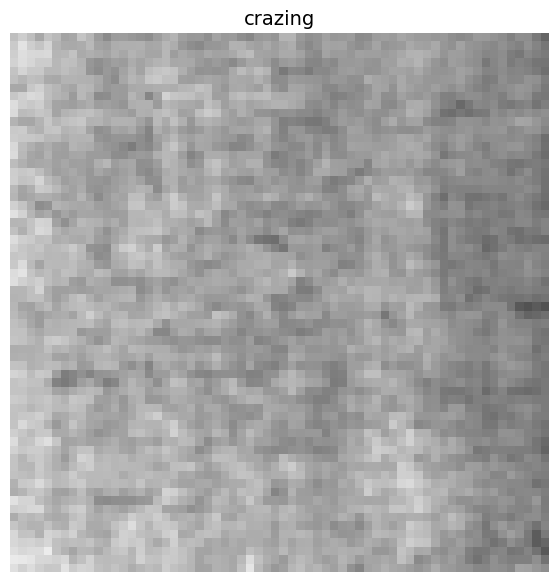

In [58]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize = (10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize = 14)

In [59]:
training_dataloader = DataLoader(
    training_dataset,
    batch_size = 32,
    shuffle = True,
    # # remove this to solve 'debug adapter' error in jupyter notebook
    # jupyter debugger doesn't support debugging subprocesses
    # https://github.com/microsoft/debugpy/issues/1166
    # num_workers = 1 
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size = 32,
    shuffle = False,
    num_workers = 0
)

In [60]:
#### 

In [61]:
class VGG11_BN(nn.Module):
    def __init__(self, num_classes = 1000):
        super(VGG11_BN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, padding = 1),
            # faster and more stable training of neural networks
            # shifting the inputs to have zero mean and unit variance
            nn.BatchNorm2d(64),
            # inplace = True, directly modify the input tensor and the input tensor is changed to the output tensor
            # no new tensors are created, more memory-efficient
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2), # stride by default follow kernel size

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2),

            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2),

            nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2),

            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [62]:
# create an instance of the vgg16 model
vgg11_bn = VGG11_BN(num_classes = len(class_names))
vgg11_bn.to(device)
# view architecture of the model
print(vgg11_bn)

VGG11_BN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool

In [63]:
img_batch, label_batch = next(iter(training_dataloader))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

Single image shape: torch.Size([1, 3, 64, 64])



In [64]:
vgg11_bn.eval()
with torch.inference_mode():
    pred = vgg11_bn(img_single.to(device))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Output logits:
tensor([[ 0.0103,  0.0159,  0.0067, -0.0031, -0.0071, -0.0031]],
       device='cuda:0')

Output prediction probabilities:
tensor([[0.1678, 0.1688, 0.1672, 0.1656, 0.1649, 0.1656]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
1


In [65]:
summary(vgg11_bn, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
VGG11_BN                                 [1, 6]                    --
├─Sequential: 1-1                        [1, 512, 2, 2]            --
│    └─Conv2d: 2-1                       [1, 64, 64, 64]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 64, 64]           128
│    └─ReLU: 2-3                         [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 128, 32, 32]          73,856
│    └─BatchNorm2d: 2-6                  [1, 128, 32, 32]          256
│    └─ReLU: 2-7                         [1, 128, 32, 32]          --
│    └─MaxPool2d: 2-8                    [1, 128, 16, 16]          --
│    └─Conv2d: 2-9                       [1, 256, 16, 16]          295,168
│    └─BatchNorm2d: 2-10                 [1, 256, 16, 16]          512
│    └─ReLU: 2-11                        [1, 256, 16, 16]          --


In [66]:
# CrossEntropyLoss() loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = vgg11_bn.parameters(), lr = 0.001)

for epoch in tqdm(range(5)):
    vgg11_bn.train()
    train_loss, train_acc = 0, 0

    for batch, (x, y) in enumerate(training_dataloader):
        x, y = x.to(device), y.to(device)

        y_pred = vgg11_bn(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(training_dataloader)
    train_acc = train_acc / len(training_dataloader)

    print(train_loss, train_acc)

    vgg11_bn.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(validation_dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = vgg11_bn(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim = 1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
        
        test_loss = test_loss / len(validation_dataloader)
        test_acc = test_acc / len(validation_dataloader)

        print(test_loss, test_acc)


  0%|          | 0/5 [00:00<?, ?it/s]

8.977734581629436 0.24027777777777778
1.9605288803577423 0.1328125
1.704686509238349 0.35
2.0578005562225976 0.4192708333333333
1.3680244167645772 0.45555555555555555
1.0774189059933026 0.6171875
1.2863350179460313 0.5104166666666666
1.2398756245772045 0.5416666666666666
1.2388565566804675 0.5340277777777778
1.1488042045384645 0.59375
